In [1]:
import pandas as pd
# from analysis import recall_matrix
from sqlalchemy import create_engine, MetaData, Table
import json
import pandas as pd
import numpy as np
import math
from __future__ import division
import re
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.ma as ma
from itertools import izip_longest
from collections import Counter
#from analysis import recall_matrix
import pyrec as pyr


<h1> Import Data </h1>

In [2]:
# seaborn settings
sns.set_context("notebook")
sns.set_style(style='darkgrid')
sns.set_palette(palette='deep')
%matplotlib inline



db_url = "sqlite:///participants.db"
table_name = 'turkdemo'
data_column_name = 'datastring'



# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

data = []
for row in rows:
    data.append(row[data_column_name])
    
# Now we have all participant datastrings in a list.
# Let's make it a bit easier to work with:

# parse each participant's datastring as json object
# and take the 'data' sub-object
data = [json.loads(part)['data'] for part in data if part is not None]

# insert uniqueid field into trialdata in case it wasn't added
# in experiment:
for part in data:
    for record in part:
#         print(record)
        if type(record['trialdata']) is list:

            record['trialdata'] = {record['trialdata'][0]:record['trialdata'][1]}
        record['trialdata']['uniqueid'] = record['uniqueid']
        
# flatten nested list so we just have a list of the trialdata recorded
# each time psiturk.recordTrialData(trialdata) was called.
def isNotNumber(s):
    try:
        float(s)
        return False
    except ValueError:
        return True

data = [record['trialdata'] for part in data for record in part]

# filter out fields that we dont want using isNotNumber function
filtered_data = [{k:v for (k,v) in part.items() if isNotNumber(k)} for part in data]
    
# Put all subjects' trial data into a dataframe object from the
# 'pandas' python library: one option among many for analysis
data_frame = pd.DataFrame(filtered_data)


<h1> Track Experiment Number

In [4]:
db_url = "sqlite:///participants.db"
table_name = 'turkdemo'
data_column_name = 'codeversion'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

versions = []
for row in rows:
    versions.append(row[data_column_name])
    
version_col = []
for idx,sub in enumerate(data_frame['uniqueid'].unique()):
    for i in range(sum(data_frame['uniqueid']==sub)):
        version_col.append(versions[idx])
data_frame['exp_version']=version_col


<h1> Word Pool

In [40]:

# read in stimulus library
wordpool = pd.read_csv('~/Documents/github/FRFR-analyses/stimuli/cut_wordpool.csv')


# <h1>Select Experiment</h1>

# In[73]:

subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

d = dict()
for sub in subids:
    key = data_frame[data_frame['uniqueid']==sub]['exp_version'].values[0]
    if key in d:
        d[key].append(sub)
    else:
        d[key]=[sub]

#reaplce these values with the experiment number
#three values for the case of experiment 1 only
#print (d["0.0"], d['1.0'], d['1.1'])

#exp1=d["0.0"]+d['1.0']+d['1.1']
exp1=d["5.1"]

#exp4
exp1.remove('debug4PXFJG:debug3V9BT9')


#FOR 3.2
exp1.remove('debugW6SI9R:debugWV03M1')
exp1.remove('debugY7YP43:debugYO0IUE')
exp1.remove('debugCBO3BC:debug2NEZI7')

#FOR 1
# exp1.remove('debugGPNALW:debugXSJ1FD')
# exp1.remove('debugLXMXTP:debugJAXRZL')
# exp1.remove('debugHP65NS:debugLWS9KB')
# exp1.remove('debugKUWU41:debug9FG9EP')


# subids.remove('debug4PXFJG:debug3V9BT9')
# subids.remove('debugAD2211:debugB3TKJQ')
# subids.remove('debug7XDZDR:debugO8OCCV') # all of the audio files are empty ?!
# subids.remove('debugTX7U35:debugZFTPLT')
##################


ValueError: list.remove(x): x not in list

<h1>Processing Functions</h1>

In [41]:


# this function takes the data frame and returns subject specific data based on the subid variable
def filterData(data_frame,subid):
    filtered_stim_data = data_frame[data_frame['stimulus'].notnull() & data_frame['listNumber'].notnull()]
    filtered_stim_data = filtered_stim_data[filtered_stim_data['trial_type']=='single-stim']
    filtered_stim_data =  filtered_stim_data[filtered_stim_data['uniqueid']==subid]
    return filtered_stim_data

# this function parses the data creating an array of dictionaries, where each dictionary represents a trial (word presented) along with the stimulus attributes
def createStimDict(data):
    stimDict = []
    for index, row in data.iterrows():
        stimDict.append({
                'text': str(re.findall('>(.+)<',row['stimulus'])[0]),
                'color' : { 'r' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[0]),
                           'g' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[1]),
                           'b' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[2])
                           },
                'location' : {
                    'top': float(re.findall('top:(.+)\%;', row['stimulus'])[0]),
                    'left' : float(re.findall('left:(.+)\%', row['stimulus'])[0])
                    },
                'category' : wordpool['CATEGORY'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'size' : wordpool['SIZE'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'wordLength' : len(str(re.findall('>(.+)<',row['stimulus'])[0])),
                'firstLetter' : str(re.findall('>(.+)<',row['stimulus'])[0])[0],
                'listnum' : row['listNumber']
            })
    return stimDict

# this function loads in the recall data into an array of arrays, where each array represents a list of words
def loadRecallData(subid):
    recalledWords = []
    for i in range(0,16):
        try:
            f = open('recall_data/' + subid + '-' + str(i) + '.wav.txt', 'rb')
            try:
                spamreader = csv.reader(f, delimiter=' ', quotechar='|')
            except:
                f = open('recall_data/' + subid + '/' + subid + '-' + str(i) + '.wav.txt', 'rb')
                spamreader = csv.reader(f, delimiter=' ', quotechar='|')
        except (IOError, OSError) as e:
            print(e)
        for row in spamreader:
            recalledWords.append(row[0].split(','))
    return recalledWords

# this function computes accuracy for a series of lists
def computeListAcc(stimDict,recalledWords):
    accVec = []
    for i in range(0,16):
        stim = [stim['text'] for stim in stimDict if stim['listnum']==i]
        recalled= recalledWords[i]
        
        acc = 0
        tmpstim = stim[:]
        for word in recalled:
            if word in tmpstim:
                tmpstim.remove(word)
                acc+=1
        accVec.append(acc/len(stim))
    return accVec

<h1>Create presentedWords and recalledWords</h1>

In [42]:
experiment=[]
all_recalled=[]
all_presented=[]
for idx,sub in enumerate(exp1):

    filteredStimData = filterData(data_frame,sub)
    stimDict = createStimDict(filteredStimData)
    #get and parse subject's data

    presentedWords = [[] for i in range(0,16)]  
    for data in stimDict:
        presentedWords[int(data['listnum'])].append(data['text'])

    recalledWords = loadRecallData(sub)
    #experiment.append(recall_matrix(presentedWords, recalledWords))
    
    all_recalled.append(recalledWords)
    all_presented.append(presentedWords)

[Errno 2] No such file or directory: u'recall_data/debug7XDZDR:debugO8OCCV-0.wav.txt'


UnboundLocalError: local variable 'spamreader' referenced before assignment

<h4> skip subjects (for now) with abnormal lists</h4>

In [30]:
#exp 1
all_recalled2 = all_recalled[0:11] + all_recalled[13:14] + all_recalled[15:17]
all_presented2 = all_presented[0:11] + all_presented[13:14] + all_recalled[15:17]

#exp2
# all_recalled2 = all_recalled[1:21]
# all_presented2 = all_presented[1:21]

In [31]:
len(all_recalled)
len(all_presented)

0

In [32]:
maxs = []
for x in range(0,len(all_recalled)):
    maxs.append(max(len(l) for l in all_recalled[x]))
print(maxs)

[]


<h1/> Create pyro data object 

In [33]:
pyro = pyr.Pyro(pres = all_presented2, rec = all_recalled2)

IndexError: list index out of range

<h1> Plot SPC (Average, Av by List, Individual Subject Av)

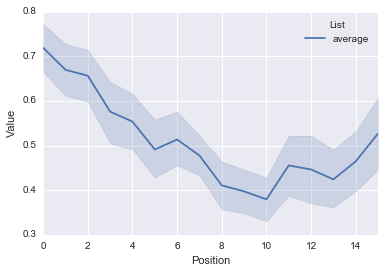

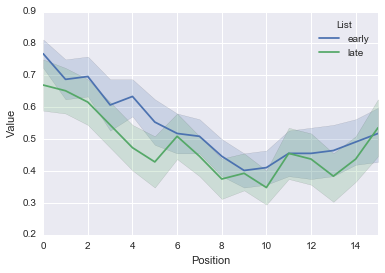

In [15]:
spc1 = pyr.spc(pyro, listgroup=['average']*16)
spc2 = pyr.spc(pyro, listgroup=['early'] * 8 + ['late'] * 8)
spc3 = pyr.spc(pyro, listgroup=['average']*16)
pyr.plot(spc1)
pyr.plot(spc2)


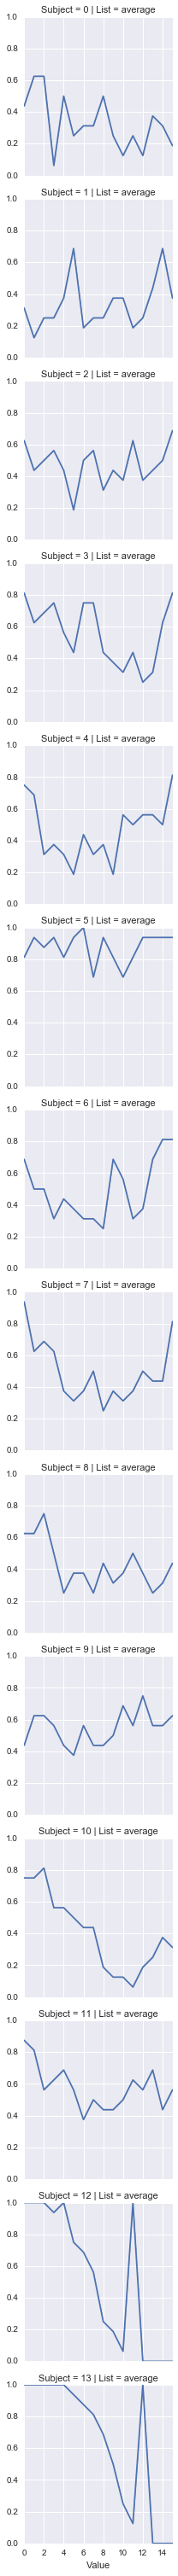

In [16]:
pyr.plot(spc1, plot_type='grid')

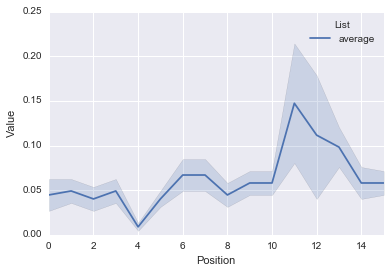

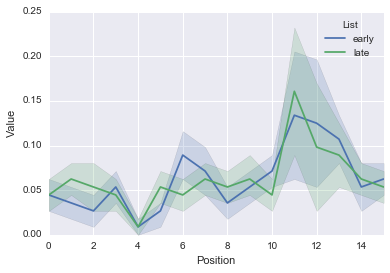

In [17]:
plr1 = pyr.plr(pyro, listgroup=['average']*16)
plr2 = pyr.plr(pyro, listgroup=['early'] * 8 + ['late'] * 8)
plr3 = pyr.plr(pyro, listgroup=['average']*16)
pyr.plot(plr1)
pyr.plot(plr2)

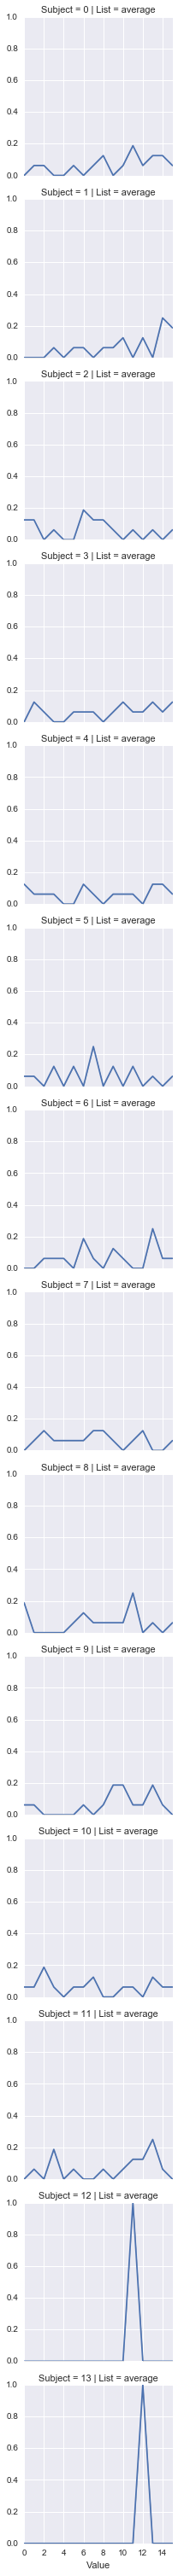

In [18]:
pyr.plot(plr1, plot_type='grid')

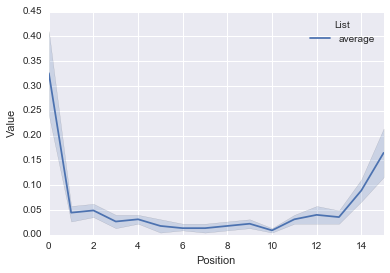

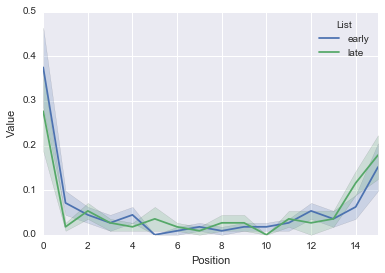

In [19]:
pfr1 = pyr.pfr(pyro, listgroup=['average']*16)
pfr2 = pyr.pfr(pyro, listgroup=['early'] * 8 + ['late'] * 8)
pfr3 = pyr.pfr(pyro, listgroup=['average']*16)
pyr.plot(pfr3)
pyr.plot(pfr2)

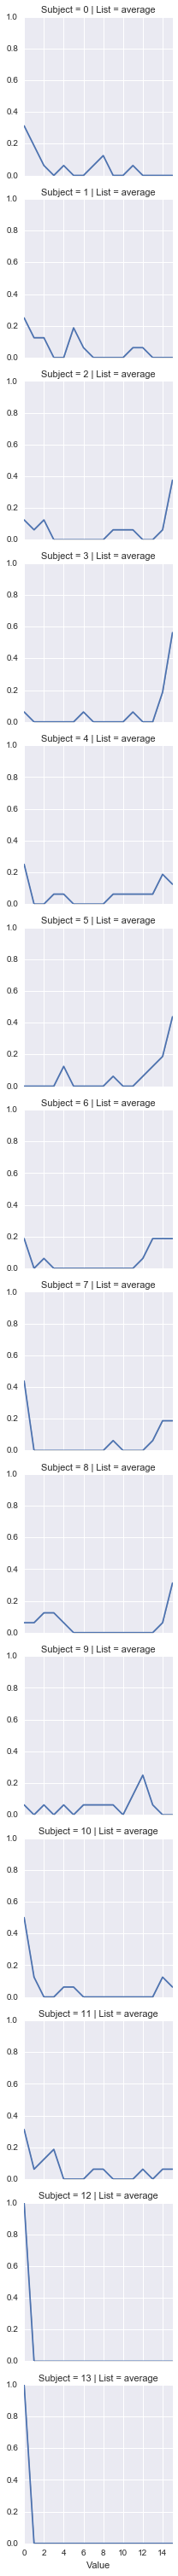

In [20]:
pyr.plot(pfr1, plot_type='grid')

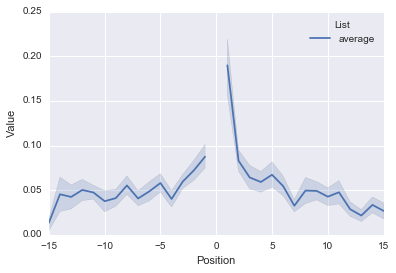

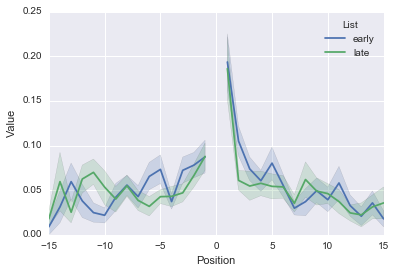

In [21]:
crp1 = pyr.lagcrp(pyro, listgroup=['average']*16)
crp2 = pyr.lagcrp(pyro, listgroup=['early'] * 8 + ['late'] * 8)
crp3 = pyr.lagcrp(pyro, listgroup=['average']*16)
pyr.plot(crp1)
pyr.plot(crp2)

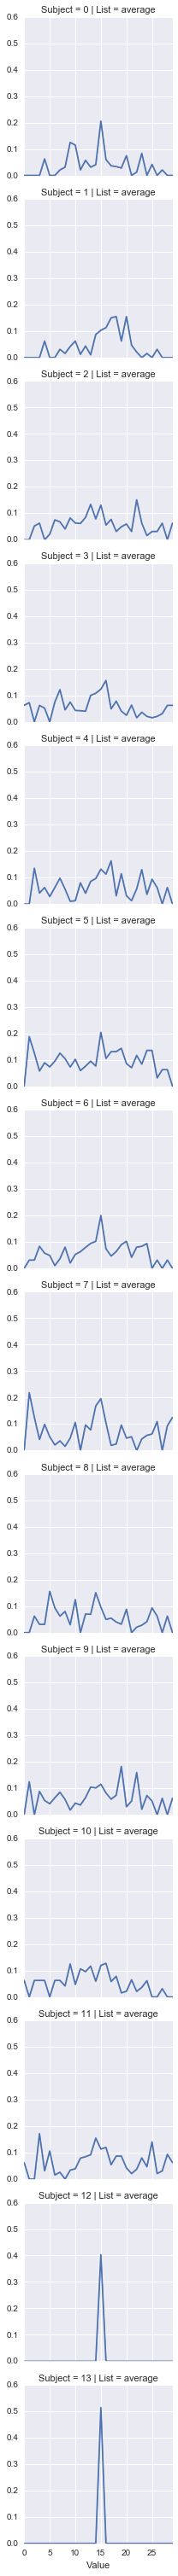

In [22]:
pyr.plot(crp1, plot_type='grid')